<a href="https://colab.research.google.com/github/nickandmartinlearnstuff/practical-deep-learning-fast-ai/blob/main/full_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
from fastbook import *
setup_book()

<div style="display:flex;">
  <h1>Nick And Martin Try To Understand The Amazon</h1>
<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/6322/media/planet.png" width=100 alt="Satellite image of agriculture, clear">
</div>

Machine Learning exercise following the Kaggle competition [Planet: Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)

In [3]:
planet = Path() /  'gdrive' / 'MyDrive' / 'data' / 'planet'

In [4]:
planet

Path('gdrive/MyDrive/data/planet')

In [5]:
df = pd.read_csv(planet / 'train_v2.csv')

In [6]:
df.describe()

,image_name,tags
count,40479,40479
unique,40479,449
top,train_22676,clear primary
freq,1,13636


In [7]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Let's define the functions to gather the data (`get_x()`) and the labels (`get_y()`).

In [8]:
planet

Path('gdrive/MyDrive/data/planet')

For some reason, we have a double-folder structure `train-jpg/train-jpg`, so we're adding this for now.

In [11]:
def get_x(row): 
  return planet / 'train-jpg' / 'train-jpg' / (row['image_name'] + '.jpg')

def get_y(row): 
  return row['tags'].split()

For some reason, there are way fewer images in the folder we untared than there are entries in the CSV file, so we needed to remove the rows from the DataFrame that refer to files we don't have.

In [38]:
all_file_names = (planet / 'train-jpg' / 'train-jpg').ls()

In [23]:
len(all_file_names)  # actual number of files we have

11731

In [26]:
len(df['image_name'])  # number of files in the CSV file

40479

One file that flagged and threw an error was `train_19831.jpg`, so we checked on whether this file exists:

In [22]:
'train_19831' in [f.stem for f in all_file_names] # train_19831.jpg

False

We create a new pandas Series object from the `.stem` of the `all_file_names` list:

In [27]:
fdf = pd.Series([f.stem for f in all_file_names])

In [29]:
len(fdf)

11731

We only keep the rows from the CSV dataframe that are also in the `all_file_names` list. We call the file DataFrame `cdf`.

In [33]:
cdf = df[df.image_name.isin(fdf)]

In [34]:
len(cdf)  # clean dataframe with only entries that we actually have images for

11731

In [35]:
dblock_resize = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dsets_r = dblock_resize.datasets(cdf)
dsets_r.train[0]

(PILImage mode=RGB size=256x256,
 TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [36]:
dls_r = dblock_resize.dataloaders(cdf)
learn_r = cnn_learner(dls_r, resnet50, metrics=partial(accuracy_multi, thresh=0.62))

In [37]:
learn_r.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.774559,0.540770,0.864676,42:06
1,0.334477,0.158989,0.945765,01:02
2,0.172036,0.137571,0.948799,01:00
3,0.151209,0.135166,0.950705,01:01


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135143,0.126235,0.954140,01:04
1,0.122191,0.108129,0.958477,01:04
2,0.108236,0.104594,0.959380,01:12


In [39]:
learn_r.export(planet / 'full-learner.pkl')

In [ ]:
preds_r,targs_r = learn_r.get_preds()

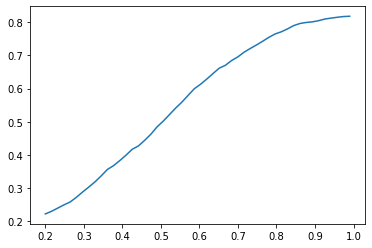

In [ ]:
xs_r = torch.linspace(0.2,0.99,50)
accs_r = [accuracy_multi(preds_r, targs_r, thresh=i, sigmoid=False) for i in xs_r]
plt.plot(xs_r,accs_r);

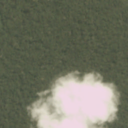

((#3) ['cultivation','partly_cloudy','primary'],
 tensor([False, False, False, False, False, False, False, False,  True, False, False,  True,  True, False, False, False, False]),
 tensor([4.3913e-02, 9.2525e-02, 8.0969e-02, 9.5631e-02, 8.5133e-02, 3.3228e-04, 2.6724e-01, 2.7310e-01, 6.2891e-01, 1.6544e-01, 1.7791e-01, 9.9710e-01, 8.2400e-01, 4.1025e-03, 3.6797e-01, 1.0486e-01,
         1.2738e-01]))

In [ ]:
img = PILImage.create('/content/gdrive/MyDrive/data/planet/test-jpg/test_237.jpg')
display(img.to_thumb(128,128))
learn.predict(img)

In [ ]:
data[2][8]

tensor(0.6289)

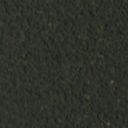

((#2) ['clear','primary'],
 tensor([False, False, False, False, False,  True, False, False, False, False, False, False,  True, False, False, False, False]),
 tensor([0.0417, 0.2354, 0.1907, 0.2366, 0.1751, 0.9918, 0.1740, 0.2355, 0.1708, 0.1554, 0.2391, 0.0470, 0.8896, 0.0832, 0.2421, 0.2552, 0.1347]))

In [ ]:
img = PILImage.create('/content/gdrive/MyDrive/data/planet/test-jpg/test_999.jpg')
display(img.to_thumb(128,128))
learn.predict(img)

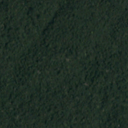

((#2) ['clear','primary'],
 tensor([False, False, False, False, False,  True, False, False, False, False, False, False,  True, False, False, False, False]),
 tensor([0.0541, 0.2110, 0.1808, 0.2012, 0.2537, 0.9919, 0.0847, 0.1586, 0.2093, 0.1146, 0.1648, 0.0399, 0.9295, 0.0530, 0.2363, 0.1446, 0.0683]))

In [ ]:
img = PILImage.create('/content/gdrive/MyDrive/data/planet/test-jpg/test_42.jpg')
display(img.to_thumb(128,128))
learn.predict(img)

`test_7.jpg` try again and find a way to up the threshold? activation? (the thing that makes it kick in only higher than at 0.5x (because those seemed wrong)